In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
import matplotlib.ticker as plticker

from data_collection.analysis.utils import get_tweets_from_json_file, is_covid_related_tweet, get_tweet_words
from data_collection.analysis import visualizations as vz

In [2]:
tweets = get_tweets_from_json_file("ug_tweets")

In [3]:
print(len(tweets))

20000


In [4]:
def process_tweet(tweet: dict) -> dict:
    """Process tweets from raw files"""
    user_id = tweet['author_id']
    tweet_id = tweet['id']
    created_time = dateutil.parser.parse(tweet['created_at']).replace(tzinfo=None)
    text = tweet['text']
    words = get_tweet_words(text)
    retweet_count = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    quote_count = tweet['public_metrics']['quote_count']
    like_count = tweet['public_metrics']['like_count']
    engagement = retweet_count + reply_count + quote_count + like_count
    is_covid = is_covid_related_tweet(words)
    source = tweet['source']

    return {
        'user_id': user_id,
        'tweet_id': tweet_id,
        'created_time': created_time,
        'text': text,
        'words': words,
        'retweet_count': retweet_count,
        'reply_count': reply_count,
        'quote_count': quote_count,
        'like_count': like_count,
        'engagement': engagement,
        'is_covid': is_covid,
        'source': source
    }


def create_pd_from_tweets(tweets) -> pd.DataFrame:
    df = pd.DataFrame([process_tweet(tweet) for tweet in tweets])
#     df.set_index('created_time', inplace=True)
    return df

In [5]:
df = create_pd_from_tweets(tweets)
df['created_time'] = pd.to_datetime(df['created_time'], errors='coerce').dt.date

In [6]:
df.head()

,user_id,tweet_id,created_time,text,words,retweet_count,reply_count,quote_count,like_count,engagement,is_covid,source
0,628614226,1366176238373634048,2021-02-28,Happy New month https://t.co/4QRUVHFiw2,"[happy, month]",2,7,0,183,192,False,Twitter for Android
1,1169513881489858561,1366176080260976647,2021-02-28,RT @macyjemi: Anyone awake 🧐??\n I want us to ...,"[anyone, awake, want, talk, something, urgent]",3,0,0,0,3,False,Twitter for Android
2,894261468,1366175958970093568,2021-02-28,RT @ssenfukamalik: Members of Majlis Khuddamul...,"[members, majlis, khuddamul, ahmadiyya, uganda...",13,0,0,0,13,False,Twitter for iPhone
3,1284584639420600320,1366175795035729920,2021-02-28,Anyone awake 🧐??\n I want us to talk something...,"[anyone, awake, want, talk, something, urgent]",3,10,0,43,56,False,Twitter for Android
4,1284584639420600320,1366175439178366976,2021-02-28,@123rayrunner Naye gwe twakola loss 😂😂😂🤣🤣,"[naye, twakola, loss, 😂😂😂🤣🤣]",0,1,0,2,3,False,Twitter for Android


In [7]:
vz.summary(df)

Number of tweets: 20000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        20000 non-null  object
 1   tweet_id       20000 non-null  object
 2   created_time   20000 non-null  object
 3   text           20000 non-null  object
 4   words          20000 non-null  object
 5   retweet_count  20000 non-null  int64 
 6   reply_count    20000 non-null  int64 
 7   quote_count    20000 non-null  int64 
 8   like_count     20000 non-null  int64 
 9   engagement     20000 non-null  int64 
 10  is_covid       20000 non-null  bool  
 11  source         20000 non-null  object
dtypes: bool(1), int64(5), object(6)
memory usage: 1.7+ MB
Columns:
None


In [8]:
covid_df = df[df['is_covid'] == True]

In [9]:
covid_df.head()

,user_id,tweet_id,created_time,text,words,retweet_count,reply_count,quote_count,like_count,engagement,is_covid,source
14,912204877757059072,1366170863561760768,2021-02-28,"@ntvuganda Sheikh Muzata was killed, I'd doesn...","[sheikh, muzata, killed, need, bishop, archbis...",0,0,0,0,0,True,Twitter for Android
492,1346361755593814017,1366126207612448772,2021-02-28,@Rociwells2021 @karmajusticiera @PODEMOS @nach...,"[llevas, toda, razón, pero, necesitas, twitter...",0,0,0,0,0,True,Twitter for Android
1507,1246539661306138630,1366093048489336833,2021-02-28,RT @douglasrasbash: @TheRealRuncey @SkyNews Tr...,"[true, covid, graves, prepared, outside, paulo]",1,0,0,0,1,True,Twitter for iPhone
1764,2184672177,1366084886696783872,2021-02-28,RT @douglasrasbash: @Elliemaexx__ @SkyNews Abo...,"[virus, mutations, recorded, whether, fear, co...",1,0,0,0,1,True,Twitter for iPhone
1778,1013221658,1366084217445249024,2021-02-28,@Elliemaexx__ @SkyNews About 40 virus mutation...,"[virus, mutations, recorded, whether, fear, co...",1,0,0,3,4,True,Twitter for iPhone


Number of COVID tweets: 38


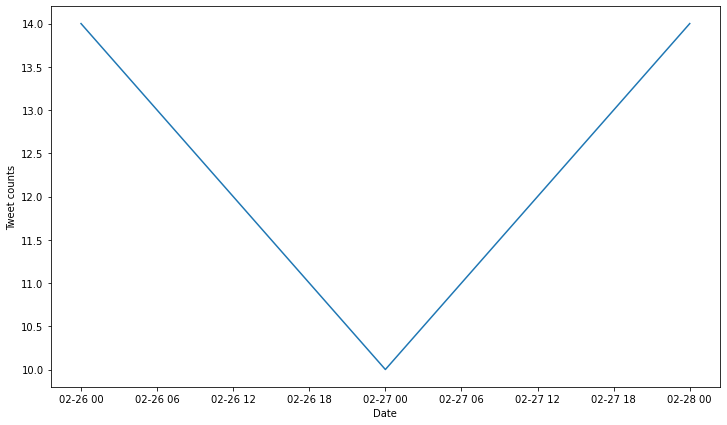

In [10]:
def summarise_covid_tweets(covid_df: pd.DataFrame, mode="moh"):
    print(f"Number of COVID tweets: {covid_df.shape[0]}")

    daily_covid = covid_df['tweet_id'].groupby([covid_df['created_time']]).count()
    ax = daily_covid.plot(figsize=(12, 7))
    ax.set(ylabel="Tweet counts")
    ax.set(xlabel="Date")

    plt.show()

summarise_covid_tweets(covid_df)

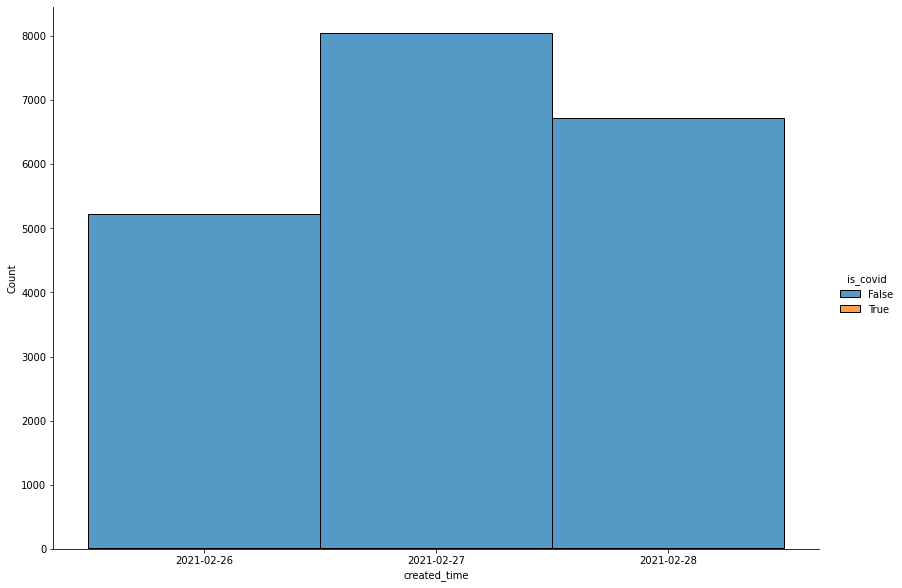

In [11]:
# _, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8)
g = sns.displot(df, x="created_time", hue="is_covid", multiple="stack", height=8.27, aspect=11.7/8.27)
x_dates = df['created_time'].sort_values().unique()
# g.set_xticklabels(labels=x_dates, rotation=45, horizontalalignment='right')
g.set(xticks=x_dates)
# g.fig.autofmt_xdate()

<AxesSubplot:>

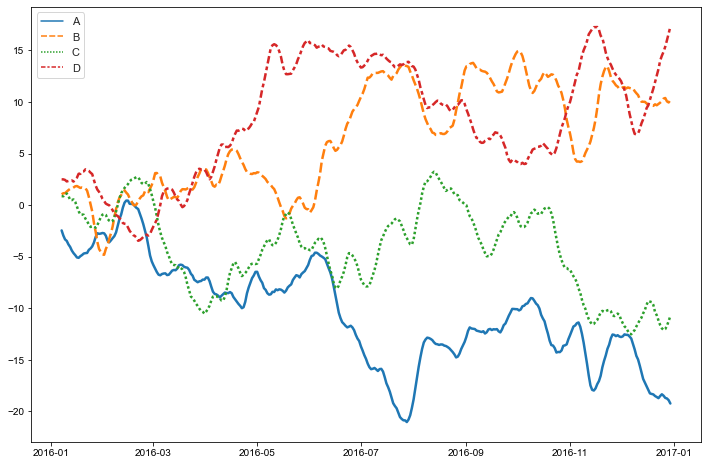

In [12]:
# Example line plot
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.set_theme(style="whitegrid")

rs = np.random.RandomState(365)
values = rs.randn(365, 4).cumsum(axis=0)
dates = pd.date_range("1 1 2016", periods=365, freq="D")
data = pd.DataFrame(values, dates, columns=["A", "B", "C", "D"])
data = data.rolling(7).mean()
sns.lineplot(data=data, palette="tab10", linewidth=2.5)

In [13]:
covid_df.set_index('created_time', inplace=True)

<AxesSubplot:>

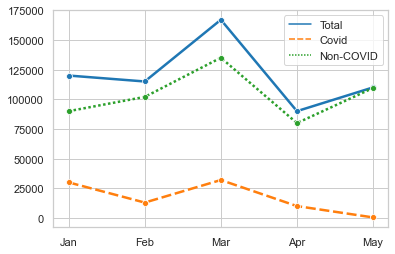

In [14]:
values = np.array([[120000, 30000], [115000, 13000], [167000, 32000], [90000, 10040], [110000, 500]])
non_covid = values[:,0] - values[:,1]
values = np.append(values, non_covid.reshape(values.shape[0], 1), axis=1)
months = ["Jan", "Feb", "Mar", "Apr", "May"]
data = pd.DataFrame(values, months, columns=["Total", "Covid", "Non-COVID"])
sns.lineplot(data=data, palette="tab10", marker='o', linewidth=2.5)

In [19]:
# Actual Ugandan tweets
from data_collection.twitterv2.db_utils import retrieve_tweets

ModuleNotFoundError: No module named 'pymongo'

In [161]:
ug_tweets = retrieve_tweets("ugandan")
print(len(ug_tweets))

12992


In [175]:
classified_tweets = [tweet for tweet in ug_tweets if 'prediction' in tweet]
print(len(classified_tweets))
covid_tweets = [tweet for tweet in classified_tweets if tweet['prediction']['classification'] == 'Covid']
print(f"Covid tweets: {len(covid_tweets)}")

2800
Covid tweets: 140


In [169]:
import json
sample_tweet = classified_tweets[0]
# sample_tweet.pop('_id')
print(json.dumps(sample_tweet, indent=4))

<class 'str'>
{
    "author_id": "628614226",
    "public_metrics": {
        "retweet_count": 2,
        "reply_count": 7,
        "like_count": 183,
        "quote_count": 0
    },
    "created_at": "2021-02-28T23:59:32.000Z",
    "text": "Happy New month https://t.co/4QRUVHFiw2",
    "id": "1366176238373634048",
    "geo": {
        "place_id": "000c69ad123213a8"
    },
    "conversation_id": "1366176238373634048",
    "source": "Twitter for Android",
    "classification": {
        "class": "covid",
        "confidence": 0.5
    },
    "prediction": {
        "probabilities": {
            "Non-Covid": 0.9995600581169128,
            "Covid": 0.0004399318131618202
        },
        "classification": "Non-Covid",
        "confidence": 0.9995600581169128
    }
}


In [16]:
from datetime import datetime
months = {1: "Jan", 2: "Feb", 3: "March", 4: "April", 5: "May", 6: "June", 
          7: "July", 8: "Aug", 9: "Sept", 10: "Oct", 11: "Nov", 12: "Dec"}
def get_month_word(created_time: datetime=None, year=None, month=None):
    if created_time is not None:
        month_word = f"{months[created_time.month]} {created_time.year}"
    else:
        month_word = f"{months[month]} {year}"
    return month_word
    
def process_tweet(tweet):
    created_time = dateutil.parser.parse(tweet['created_at']).replace(tzinfo=None)
    month = f"{months[created_time.month]} {created_time.year}"
    retweets = tweet['public_metrics']['retweet_count']
    reply_count = tweet['public_metrics']['reply_count']
    like_count = tweet['public_metrics']['like_count']
    quote_count = tweet['public_metrics']['quote_count']
    total_engagement = retweets + reply_count + like_count + quote_count
    
    return {
        'tweet_id': tweet['id'],
        'text': tweet['text'],
        'author_id': tweet['author_id'],
        'retweet_count': retweets,
        'reply_count': reply_count,
        'like_count': like_count,
        'quote_count': quote_count,
        'engagement': total_engagement,
        'created_at': created_time,
        'month': month,
        'classification': tweet['prediction']['classification']
    }

In [21]:
# datetime_tweets = [tweet for tweet in classified_tweets if type(tweet['created_at']) == str]
# print(len(datetime_tweets))
final_tweets = [process_tweet(tweet) for tweet in classified_tweets]
df = pd.DataFrame(final_tweets)
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce').dt.date
df.head()

NameError: name 'classified_tweets' is not defined

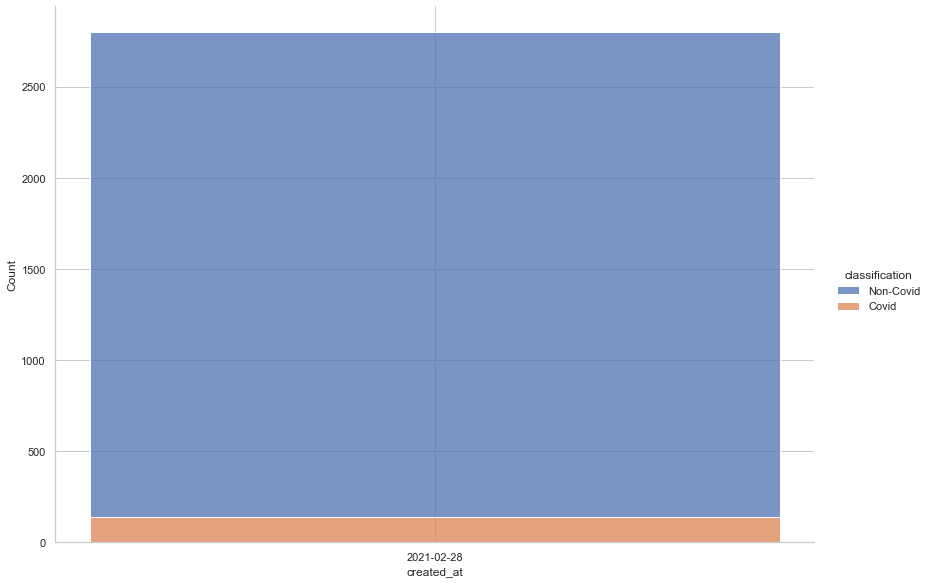

In [177]:
g = sns.displot(df, x="created_at", hue="classification", multiple="stack", height=8.27, aspect=11.7/8.27)
x_dates = df['created_at'].sort_values().unique()
# g.set_xticklabels(labels=x_dates, rotation=45, horizontalalignment='right')
g.set(xticks=x_dates)
# g.fig.autofmt_xdate()

In [17]:
# Using actual Ugandan COVID tweets
from constants import DATA_FOLDER
import json


def read_ug_tweets_json(year, month):
    filename = DATA_FOLDER.joinpath(f"{year}-{month}_covid.json")
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
        return data
    
ug_covid_tweets = dict()
years = {2020: range(3, 13), 2021: range(1, 3)}
for year in years.keys():
    for month in years[year]:
        month_word = get_month_word(year=year, month=month)
        ug_covid_tweets[month_word] = read_ug_tweets_json(year, month)
print(ug_covid_tweets.keys())

dict_keys(['March 2020', 'April 2020', 'May 2020', 'June 2020', 'July 2020', 'Aug 2020', 'Sept 2020', 'Oct 2020', 'Nov 2020', 'Dec 2020', 'Jan 2021', 'Feb 2021'])


In [18]:
def make_month_dict(month):
    month_tweets = ug_covid_tweets[month]
    total_tweets = month_tweets['total_tweets']
    covid_tweets = month_tweets['covid_tweets']
    non_covid_tweets = total_tweets - covid_tweets
    covid_percentage = (covid_tweets/total_tweets) * 100
    return {
        'Total tweets': total_tweets,
        'Covid tweets': covid_tweets,
        'Non covid tweets': non_covid_tweets,
        'Covid percentage': covid_percentage
    }
    
month_numbers_data = [make_month_dict(month) for month in ug_covid_tweets.keys()]
month_num_df = pd.DataFrame(month_numbers_data, ug_covid_tweets.keys())
month_num_df

,Total tweets,Covid tweets,Non covid tweets,Covid percentage
March 2020,178235,14937,163298,8.380509
April 2020,229512,14168,215344,6.173098
May 2020,277354,10780,266574,3.886730
June 2020,186187,4604,181583,2.472783
July 2020,161331,2803,158528,1.737422
Aug 2020,147975,2489,145486,1.682041
Sept 2020,139831,1769,138062,1.265099
Oct 2020,127716,1385,126331,1.084437
Nov 2020,133272,1543,131729,1.157783
Dec 2020,146840,1894,144946,1.289839


Text(0.5, 1.0, 'Comparison of Covid-Related Tweets to Non-Covid tweets per month')

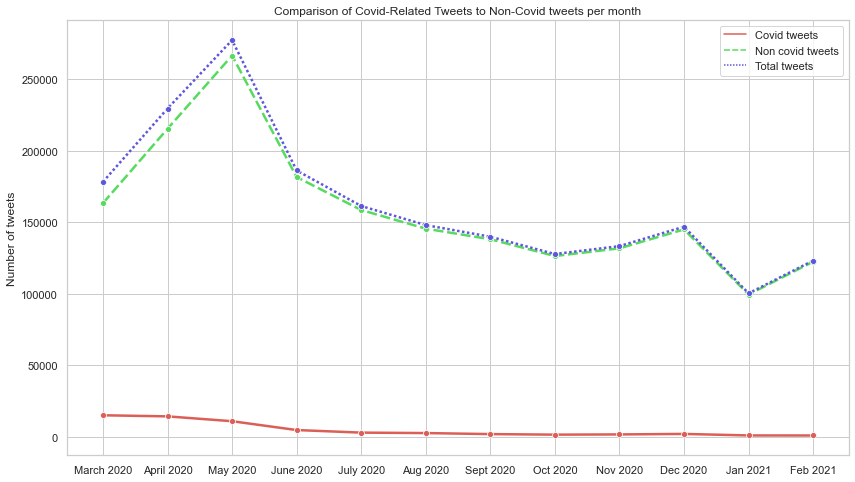

In [19]:
# Comparison with non covid tweets
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
sns.set_theme(style="whitegrid")

ax = sns.lineplot(data=month_num_df[['Covid tweets', 'Non covid tweets', 'Total tweets']], 
             palette="hls", marker='o', linewidth=2.5)
ax.set(ylabel="Number of tweets")
ax.set_title("Comparison of Covid-Related Tweets to Non-Covid tweets per month")

Text(0.5, 1.0, 'Number of Covid-related tweets per month')

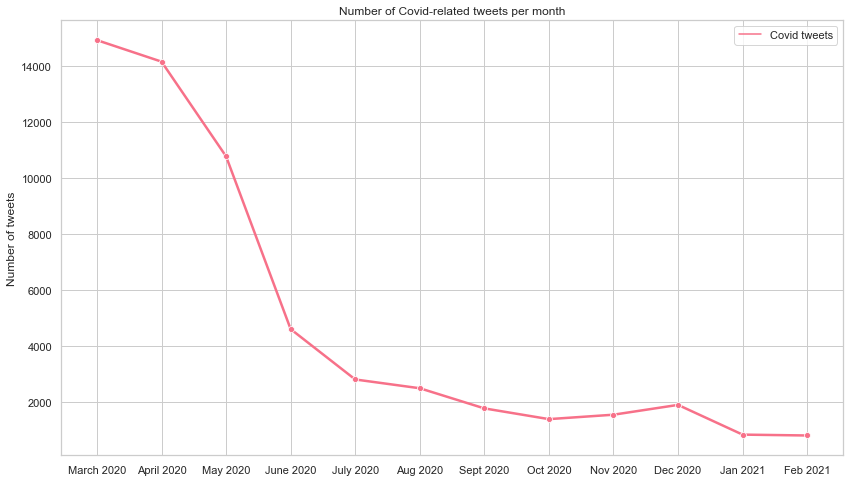

In [20]:
# Frequency of Covid tweets
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

ax = sns.lineplot(data=month_num_df[['Covid tweets']], 
             palette="husl", marker='o', linewidth=2.5)
ax.set(ylabel="Number of tweets")
ax.set_title("Number of Covid-related tweets per month")

Text(0.5, 1.0, 'Percentage of Covid-related tweets per month')

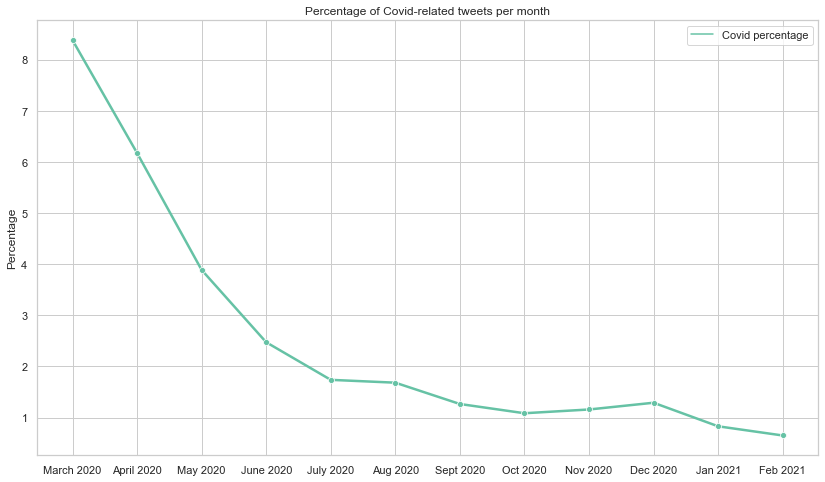

In [21]:
# Percentage of Covid tweets per month
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

ax = sns.lineplot(data=month_num_df[['Covid percentage']], 
             palette="Set2", marker='o', linewidth=2.5)
ax.set(ylabel="Percentage")
ax.set_title("Percentage of Covid-related tweets per month")

In [22]:
month_num_df[['Covid percentage']]

,Covid percentage
March 2020,8.380509
April 2020,6.173098
May 2020,3.886730
June 2020,2.472783
July 2020,1.737422
Aug 2020,1.682041
Sept 2020,1.265099
Oct 2020,1.084437
Nov 2020,1.157783
Dec 2020,1.289839


In [23]:
all_tweets = []
for month in ug_covid_tweets.keys():
    all_tweets.extend(ug_covid_tweets[month]['tweets'])

processed_tweets = [process_tweet(tweet) for tweet in all_tweets]
tweets_df = pd.DataFrame(processed_tweets)
tweets_df.head()

,tweet_id,text,author_id,retweet_count,reply_count,like_count,quote_count,engagement,created_at,month,classification
0,1245127782700584963,If a gal looks at you like this after Quaranti...,1091633123782246402,0,0,2,0,2,2020-03-31 23:16:11,March 2020,Covid
1,1245124973464825856,This mosquito 😫\nIt might even be corona mosqu...,3796868135,0,0,3,0,3,2020-03-31 23:05:01,March 2020,Covid
2,1245122920956997632,Latest East African Cases #COVID19 \n\nRwanda ...,879530560552554496,1,0,7,0,8,2020-03-31 22:56:52,March 2020,Covid
3,1245122303341494274,@fizzy______ Woke up to wash my hands and then...,1070746420578275330,1,0,1,0,2,2020-03-31 22:54:25,March 2020,Covid
4,1245120512080183299,I realize quarantine has also quarantined twee...,1113804899081424896,0,0,1,0,1,2020-03-31 22:47:17,March 2020,Covid


dict_keys(['April 2020', 'Aug 2020', 'Dec 2020', 'Feb 2021', 'Jan 2021', 'July 2020', 'June 2020', 'March 2020', 'May 2020', 'Nov 2020', 'Oct 2020', 'Sept 2020'])


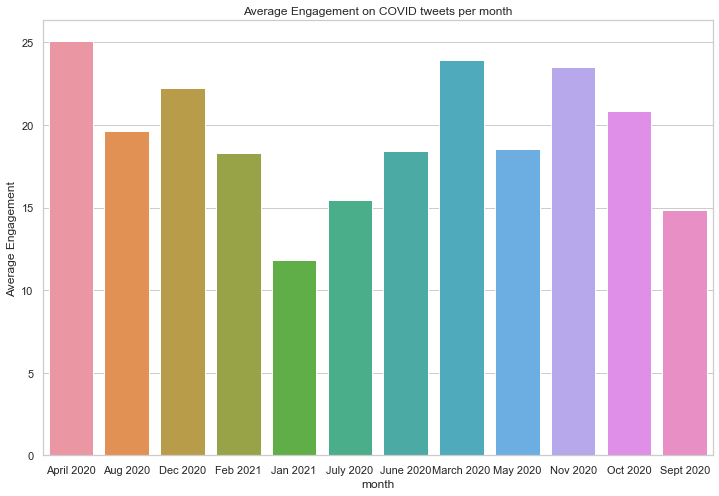

In [24]:
from data_collection.analysis.visualizations import barplot


columns = ['engagement']
eng_df = tweets_df.groupby(['month'])
aggregate = eng_df.agg([np.mean])
print(eng_df.groups.keys())
avg_eng_df = pd.DataFrame({
    'month': list(eng_df.groups.keys()),
    'Average Engagement': list(aggregate[('engagement', 'mean')])
})

barplot(data=avg_eng_df,
       xy=('month', 'Average Engagement'),
       ylabel='Average Engagement',
       title='Average Engagement on COVID tweets per month')

In [25]:
sorted_by_engagement = tweets_df.sort_values(by=['engagement'], ascending=False)
sorted_by_engagement.head()

,tweet_id,text,author_id,retweet_count,reply_count,like_count,quote_count,engagement,created_at,month,classification
37606,1257892957203685378,"I’m serious, I know Lockdown is hard on most o...",420194657,583,3500,6551,325,10959,2020-05-06 04:40:26,May 2020,Covid
4913,1242909530964594698,What a great relief that of all 104 tested peo...,3332580784,1525,591,6415,253,8784,2020-03-25 20:21:38,March 2020,Covid
25249,1247551076565422080,More good news today! 150 Samples have tested ...,4567685369,1171,615,5743,198,7727,2020-04-07 15:45:29,April 2020,Covid
6334,1242463024516038657,Thank you @JackMa and @AlibabaGroup for the do...,4567685369,1034,358,4555,141,6088,2020-03-24 14:47:23,March 2020,Covid
36002,1259804391663636480,The #COVID19 crisis in Tanzania is now critica...,96941094,1320,601,3718,287,5926,2020-05-11 11:15:47,May 2020,Covid


In [26]:
# Show top tweets per month
sorted_grouped = sorted_by_engagement.groupby(['month'])
top_10_tweets = dict()
columns = ['month', 'text', 'retweet_count', 'reply_count', 'like_count', 'quote_count']
for month, tweets in sorted_grouped:
    top_10 = tweets[0:20]
    top_10_tweets[month] = top_10.filter(columns)

def print_tweet(tweet):
    for col in columns:
        print(f"{col} -> {tweet[col]}")
    print("\n\n")

for month in ug_covid_tweets.keys():
    for i in range(0, 10):
        print_tweet(top_10_tweets[month].iloc[i])


month -> March 2020
text -> What a great relief that of all 104 tested people today  none is positive .I am sleeping soundly .May God give us sleep to compensate for all sleepless nights we have spent for 6 days
retweet_count -> 1525
reply_count -> 591
like_count -> 6415
quote_count -> 253



month -> March 2020
text -> Thank you @JackMa and @AlibabaGroup for the donation of key supplies to enhance our #COVID19 response. The items which arrived this afternoon aboard @flyethiopian include: 
-100,000 masks
-20,089 test kits
-741 Personal Protective Equipment 
-1,111 face shields https://t.co/PvkpOIQEJE
retweet_count -> 1034
reply_count -> 358
like_count -> 4555
quote_count -> 141



month -> March 2020
text -> 7 new cases of COVID-19 confirmed in Uganda today, Saturday 28 March 2020. This brings the total to 30 confirmed cases in the country. 
Out of 225 samples run today, 218 samples have tested negative for COVID-19.
retweet_count -> 1461
reply_count -> 527
like_count -> 3285
quote_cou

In [27]:
for i in range(0, 20):
    print_tweet(top_10_tweets["Feb 2021"].iloc[i])

month -> Feb 2021
text -> RT @JaneRuth_Aceng: More good news today! 150 Samples have tested negative for COVID-19. Glory to God. 
Uganda, we can do this.
retweet_count -> 1171
reply_count -> 0
like_count -> 0
quote_count -> 0



month -> Feb 2021
text -> The world is so cruel. Be nice to your loved ones and family🙏🏾
retweet_count -> 100
reply_count -> 15
like_count -> 696
quote_count -> 6



month -> Feb 2021
text -> They said they would BEAT journalists for their own protection but let me ask, what exactly was military police protecting them from at the UN Human Rights Council? 🤔 All this impunity because they don’t want cameras pointed at Bobi Wine? Delivering a frikin document? 🤷🏽‍♂️🤦🏾‍♂️🙅🏽‍♂️
retweet_count -> 112
reply_count -> 6
like_count -> 404
quote_count -> 1



month -> Feb 2021
text -> Most of Us are Used to flying to  London, New York, Moscow, Beijing... On short notice and without Visas On VPN Airlines and @GovUganda Wants us to Come back to the Dusty Streets of Kampala On

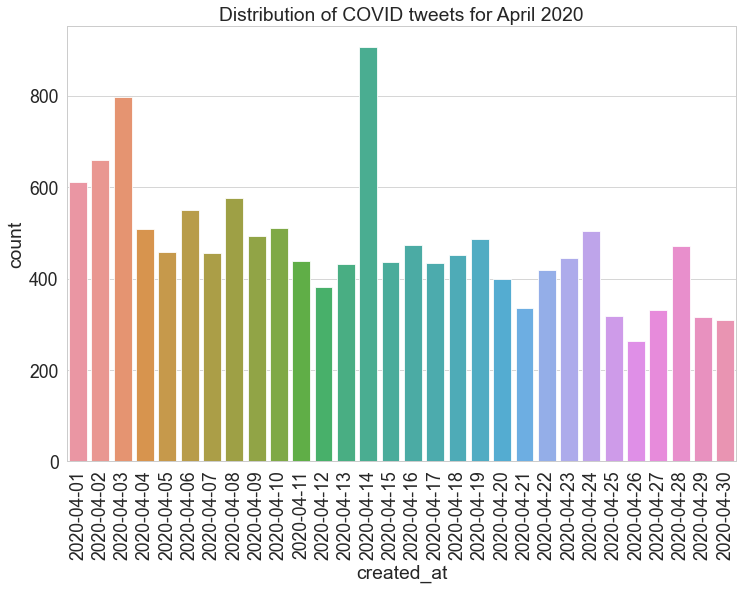

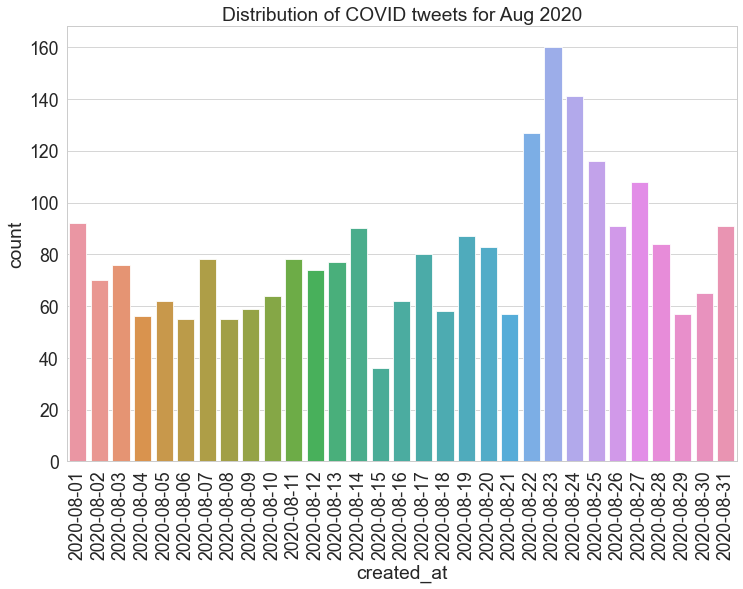

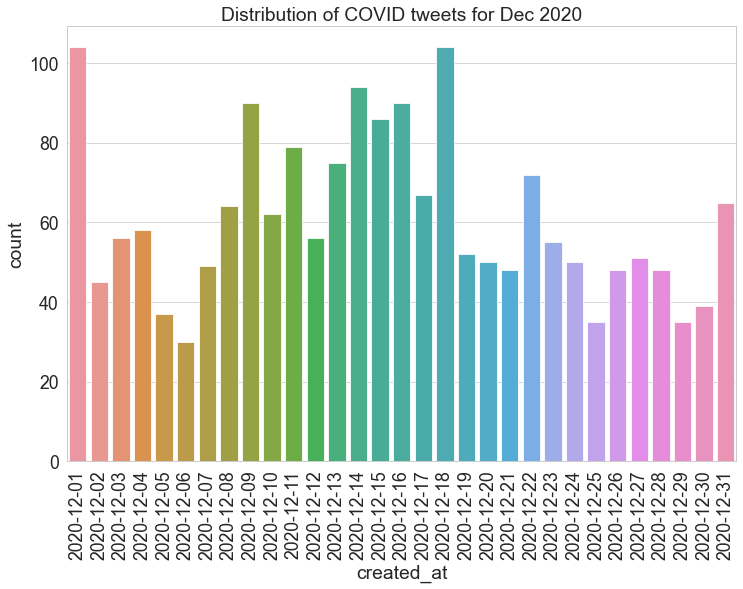

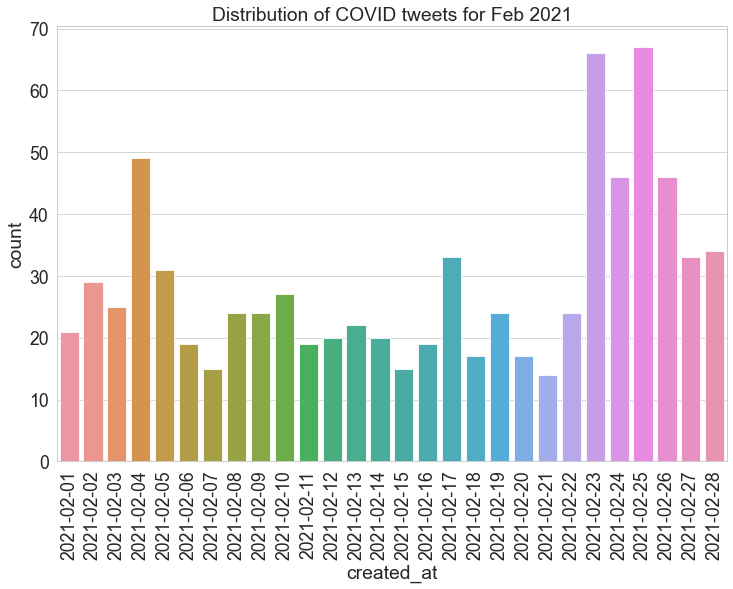

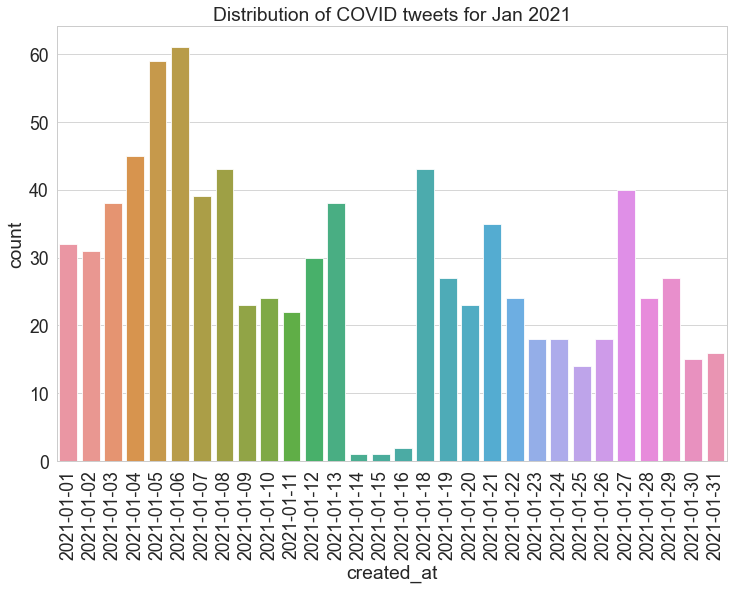

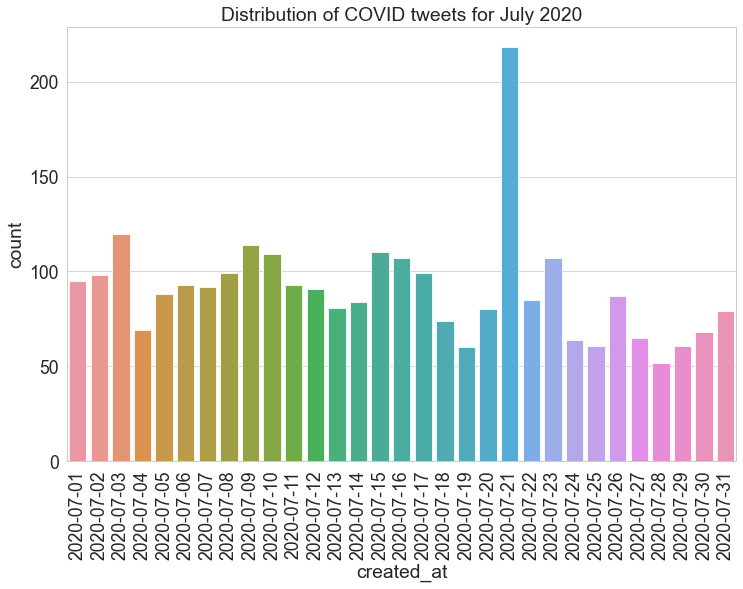

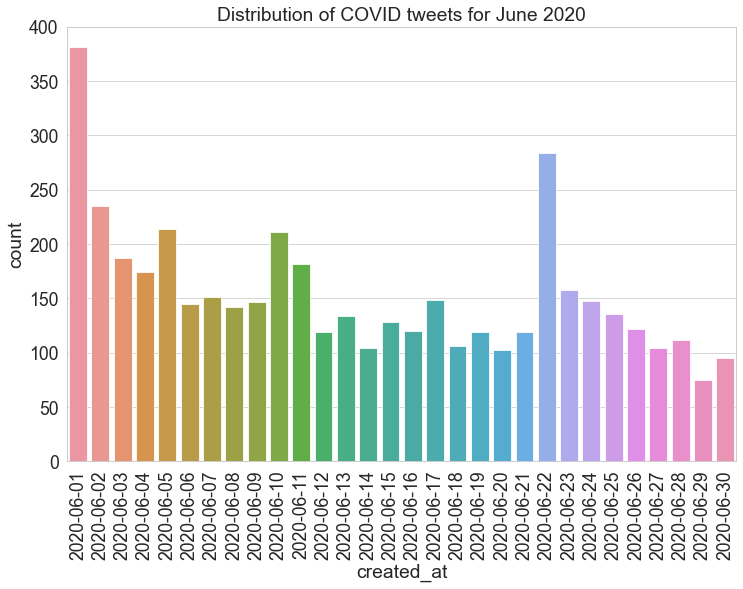

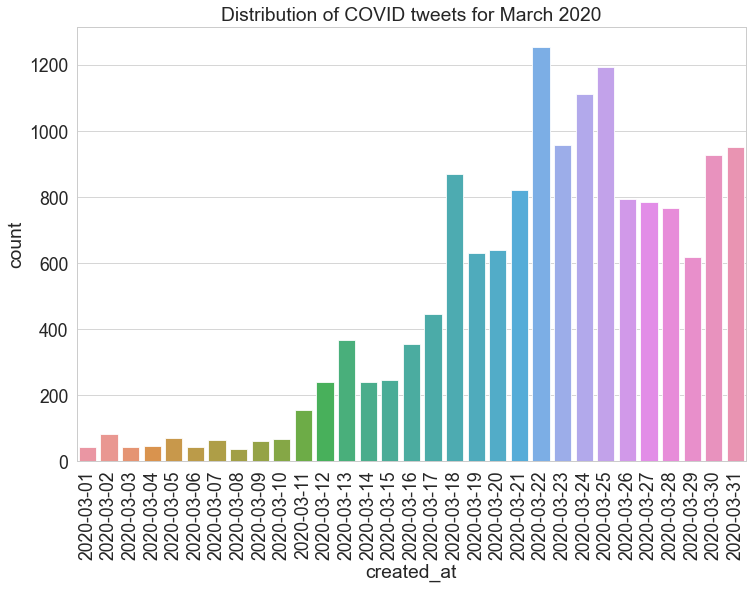

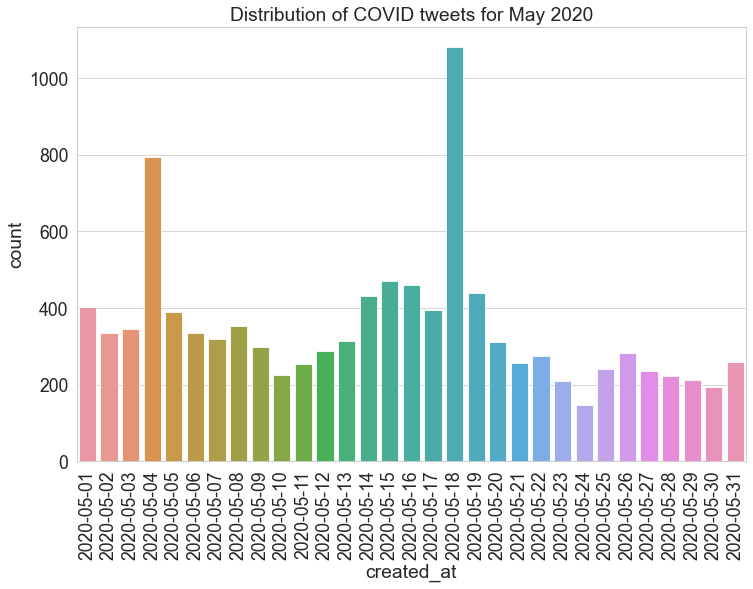

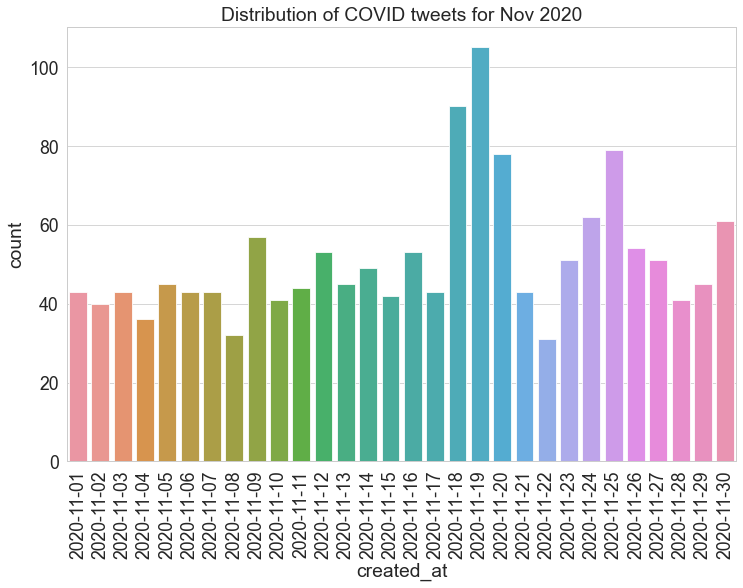

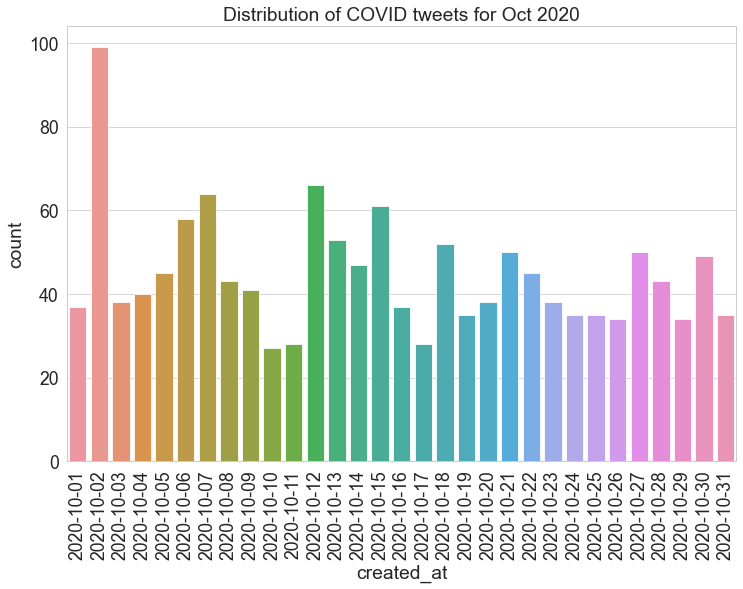

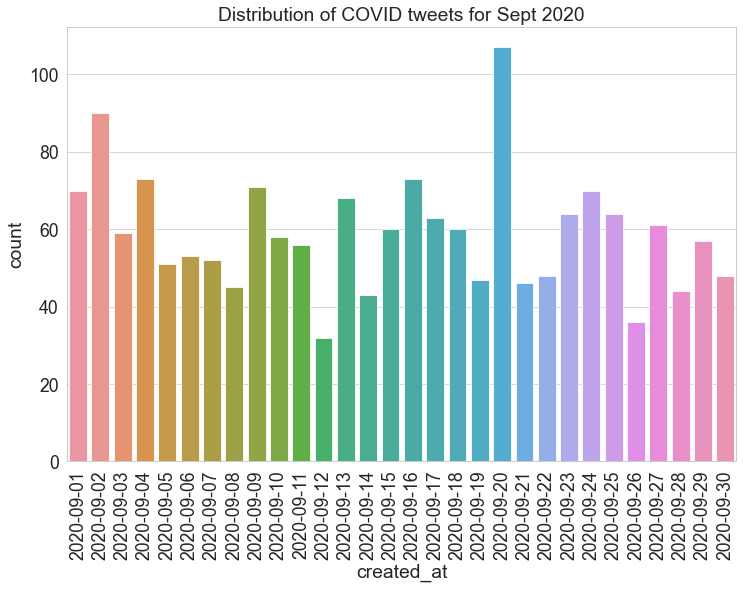

In [51]:
def plot_months_covid_data(month, covid_tweets_df):
    tweets['created_at'] = pd.to_datetime(tweets['created_at'], errors='coerce').dt.date
    sorted_tweets = tweets.sort_values(by='created_at')
    sns.set_context('paper', font_scale=2)
    _, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    ax = sns.countplot(x='created_at', data=sorted_tweets)
    ax.set_title(f"Distribution of COVID tweets for {month}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='center')

for month, tweets in eng_df:
    plot_months_covid_data(month, tweets)